## Imports

In [1]:
import os

In [2]:
import re

In [3]:
from bs4 import BeautifulSoup

In [4]:
import pandas as pd

In [5]:
#!pip3 install yiddish

In [6]:
import yiddish

## Data import and initial exploration of metadata

In [33]:
table = pd.read_csv('../preparatory_data/benyehuda_drama.12092023.tsv', sep='\t')

In [34]:
table

,TextID,Title,sort_title,Title_Wikidata,Title_VIAF,orig_publication_date,Author,WikiID,Author_EN,Author BenYehuda,...,date of birth,date of death,CombinedDate,_ - metadata - copyright_status,period,raw_publication_date,AuthorGender,TranslatorGender,_ - metadata - pby_publication_date,path
0,6958,אדיפוס המלך,אדיפוס המלך,Oedipus Rex,אדיפוס המלך,NaN,סופוקלס,Q7235,Sophocles,https://benyehuda.org/author/334,...,0496,0406,NaN,False,revival,NaN,male,male,2017-07-09,/p57/m6958
1,10777,אדמומיות,אדמומיות,אדמומיות,אדמומיות,1928-07-01,פסח גינזבורג,Q7027496,Pesaḥ Ginzburg,NaN,...,1894,1947,NaN,False,revival,"[תרפ""ח] 1928",male,NaN,2018-02-20,/p404/m10777
2,7428,אחימן ושולמית,אחימן ושולמית,אחימן ושולמית,אחימן ושולמית,NaN,טוביה בן משה כץ,NaN,NaN,NaN,...,1652‏,1729,NaN,False,medieval,NaN,male,NaN,2017-07-14,/p48/m7428
3,485,אַחֲרִית שָׁאוּל,אחרית שאול,אחרית שאול,אחרית שאול,NaN,מיכה יוסף לבנזון,Q973591,Micah Joseph Lebensohn,NaN,...,1828,1852,1870.0,False,enlightenment,NaN,male,NaN,2017-04-16,/p158/m485
4,27865,איזבל,איזבל,איזבל,איזבל,NaN,חיים הררי,Q30527645,Haim Harari,NaN,...,1883,‏1940,NaN,False,revival,"תר""ץ",male,NaN,2021-07-05,/p421/m27865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2866,קַיִן,קין,קין,קין,NaN,לורד ביירון,Q5679,Lord Byron,https://benyehuda.org/author/238,...,1788,1824,1900.0,False,revival,NaN,male,male,2017-05-14,/p142/m2866
86,6875,קשר בן נתניה,קשר בן נתניה,קשר בן נתניה,קשר בן נתניה,NaN,יהודה לודוויג פיליפסון,Q88899,Ludwig Philippson,https://benyehuda.org/author/323,...,1811,1889,1902.0,False,enlightenment,NaN,male,male,2017-07-07,/p165/m6875
87,3182,רם ויעל (רומאו ויוליה),רם ויעל רומאו ויוליה,רם ויעל רומאו ויוליה,רם ויעל רומאו ויוליה,NaN,ויליאם שייקספיר,Q692,William Shakespeare,https://benyehuda.org/author/260,...,1564,1616,NaN,False,enlightenment,NaN,male,male,2017-05-16,/p107/m3182
88,18378,שולמית,שולמית,Shulamith,שולמית,1921-07-01,אברהם גולדפדן,Q330024,Abraham Goldfaden,https://benyehuda.org/author/17,...,1840,1908,NaN,False,revival,1921,male,male,2020-03-07,/p169/m18378


In [35]:
table['html']

0     <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
1     <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
2     <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
3     <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
4     <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
                            ...                        
85    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
86    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
87    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
88    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
89    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
Name: html, Length: 90, dtype: object

In [36]:
table.columns

Index(['TextID', 'Title', 'sort_title', 'Title_Wikidata', 'Title_VIAF',
       'orig_publication_date', 'Author', 'WikiID', 'Author_EN',
       'Author BenYehuda', 'TranslatorHeb', 'Translator', 'TranslatorWikiID',
       'Translator BenYehuda', 'orig_lang', 'GithubURL', 'html',
       'Creation_Date', 'files', '_ - url', '_ - download_url',
       'date of birth', 'date of death', 'CombinedDate',
       '_ - metadata - copyright_status', 'period', 'raw_publication_date',
       'AuthorGender', 'TranslatorGender',
       '_ - metadata - pby_publication_date', 'path'],
      dtype='object')

In [37]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   TextID                               90 non-null     int64  
 1   Title                                90 non-null     object 
 2   sort_title                           90 non-null     object 
 3   Title_Wikidata                       90 non-null     object 
 4   Title_VIAF                           90 non-null     object 
 5   orig_publication_date                23 non-null     object 
 6   Author                               90 non-null     object 
 7   WikiID                               89 non-null     object 
 8   Author_EN                            89 non-null     object 
 9   Author BenYehuda                     38 non-null     object 
 10  TranslatorHeb                        38 non-null     object 
 11  Translator                        

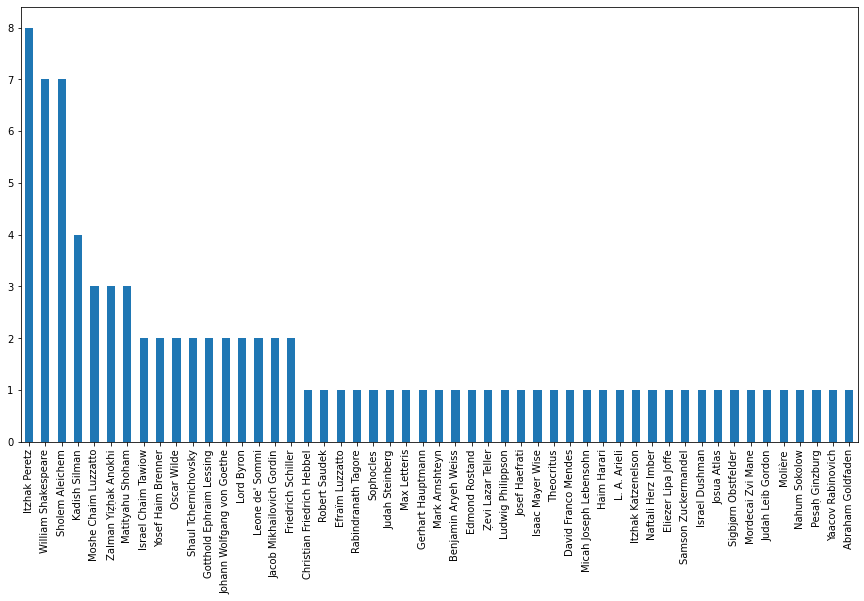

In [38]:
table['Author_EN'].value_counts().plot.bar(figsize=(15,8));

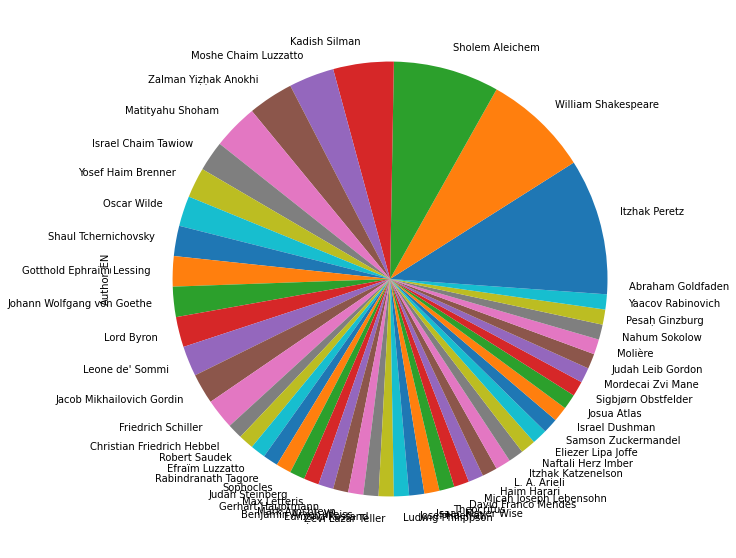

In [39]:
table['Author_EN'].value_counts().plot.pie(figsize=(10,10));

In [40]:
table = table.astype({'orig_publication_date': 'datetime64[ns]'})

In [41]:
table['orig_publication_date'].dt.year

0        NaN
1     1928.0
2        NaN
3        NaN
4        NaN
       ...  
85       NaN
86       NaN
87       NaN
88    1921.0
89    1965.0
Name: orig_publication_date, Length: 90, dtype: float64

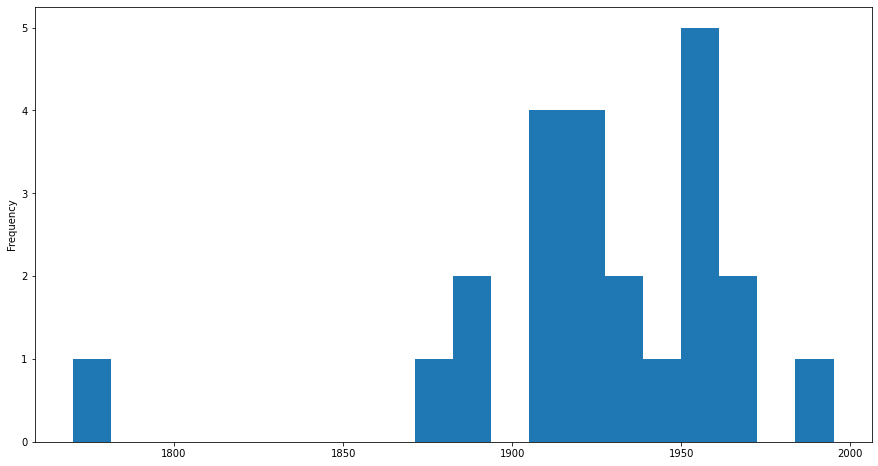

In [42]:
table['orig_publication_date'].dt.year.plot.hist(figsize=(15,8), bins=20);

## TEI creation functions

In [43]:
def parse_table(table):
    table.apply(parse_play,
                axis=1)

In [44]:
def parse_play(row):
    html = row['html']
    soup = BeautifulSoup(html)
    html_body = soup.find('body')
    tei_tree, tei_header, tei_text, tei_body = generate_tei_stub(soup)
    populate_the_tei_body(tei_body, html_body, soup)
    populate_the_tei_header(row, tei_header, soup)
    new_file_path = f'../tei/{row["TextID"]}.xml'
    with open(new_file_path, 'w') as output:
        output.write(tei_tree.prettify())

In [45]:
def populate_the_tei_body(tei_body, html_body, soup):
    all_p = html_body.find_all('p')
    for item in all_p:
        speech = parse_p(item, soup)
        #print(speech)
        tei_body.append(speech)

In [46]:
def salvage_speaker_regex(newsp, soup):
    text = newsp.text
    newsp.clear()
    lookup = re.search(r"(^[^\s]+):(.+)", text)
    if lookup is not None:
        speakername = lookup.group(1)
        speaker_id = create_id(speakername)
        newspeaker = soup.new_tag("speaker", id=speaker_id)
        newspeaker.append(speakername)
        newsp.append(newspeaker)
        newsp.append(lookup.group(2))
    else:
        newsp.append(text)

In [47]:
def parse_p(item, soup):
    newsp = soup.new_tag("sp")
    speechtext = soup.new_tag("p")
    found_bold = False
    for child in item:
        if child.name == 'strong':
            found_bold = True
            speakername = child.text
            #print(spekaername)
            speaker_id = create_id(speakername)
            newspeaker = soup.new_tag("speaker", id=speaker_id)
            newspeaker.append(speakername)
            newsp.append(newspeaker)
            #print('SUCCESS')
        else:
            speechtext.append(child)
            newsp.append(speechtext)
    if not found_bold:
        salvage_speaker_regex(newsp, soup)
    return newsp

In [48]:
def create_id(speakername):
    speakername = speakername.lower().strip('.,:!; ')
    if re.search('[אאַאָבבֿגדהוװוּױזחטייִײײַככּךלמםנןסעפּפֿףצץקרששׂתּת]', speakername):
        return (yiddish.transliterate(speakername))
    
    return (speakername)
    

In [49]:
create_id('פלָוִיוס')

'flָuִyus'

In [50]:
create_id('Daniel')

'daniel'

### TEI generation functions

In [51]:
def generate_tei_stub(soup):
    new_tree = soup.new_tag("TEI")
    new_tree['xmlns'] = "http://www.tei-c.org/ns/1.0"
    new_header = soup.new_tag("teiHeader")
    new_tree.append(new_header)
    new_text = soup.new_tag("text") 
    new_tree.append(new_text)
    new_body = soup.new_tag("body")
    new_text.append(new_body)
    return new_tree, new_header, new_text, new_body

In [52]:
def populate_the_tei_header(row, tei_header, soup):
    '''this function should take metadata from the CSV and enrich the teiHeader'''
    fdesc = soup.new_tag('fileDesc')
    titlestmt = soup.new_tag('titleStmt')
    fdesc.append(titlestmt)
    add_pbstmt(fdesc)
    add_sourcedesc(fdesc)
    tei_header.append(fdesc)
    populate_header_from_metadata(row, tei_header, soup)
    

In [53]:
def populate_header_from_metadata(row, tei_header, soup):
    author = row['Author_EN']
    add_author_to_header(tei_header, author, soup)

In [54]:
def add_author_to_header(header, line, soup):
    fdesc = header.find('titleStmt')
    author = soup.new_tag('author')
    author.append(line[7:])
    fdesc.append(author)

In [55]:
def add_title_to_header(header, line, soup):
    titlest = header.find('titleStmt')
    title = Tag(name='title')
    title['type'] = 'main'
    title.append(line[7:])
    titlest.append(title)

In [56]:
def add_pbstmt(filedesc):
    pubstmt_as_string = """
      <publicationStmt>
        <publisher xml:id="dracor">DraCor</publisher>
        <idno type="URL">https://dracor.org</idno>
        <availability>
          <licence>
            <ab>CC0 1.0</ab>
            <ref target="https://creativecommons.org/publicdomain/zero/1.0/">Licence</ref>
          </licence>
        </availability>
      </publicationStmt>
    """
    pbsoup = BeautifulSoup(pubstmt_as_string, 'xml')
    pbstmt = pbsoup.publicationStmt
    filedesc.append(pbstmt)

In [57]:
def add_sourcedesc(filedesc):
    sourcedesc_as_string = """
      <sourceDesc>
        <bibl type="digitalSource">
          <name>ENTER SOURCE NAME HERE</name>
          <idno type="URL">ENTER SOURCE URL HERE</idno>
          <availability status="free">
            <p>In the public domain.</p>
          </availability>
        </bibl>
      </sourceDesc>
    """
    sdsoup = BeautifulSoup(sourcedesc_as_string, 'xml')
    sd = sdsoup.sourceDesc
    filedesc.append(sd)

## Use

In [58]:
parse_table(table)

TypeError: 'float' object is not subscriptable